# import & data load

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,roc_curve,classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import os
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [37]:
data_path = '../data/'
filelst = os.listdir(data_path)
df = pd.DataFrame()
for file in filelst:
    if '가뭄지수' in file:
        df = pd.concat([df,pd.read_csv(data_path+file, encoding='cp949')])
df

,지점,지점명,일시,SPI1,SPI2,SPI3,SPI4,SPI5,SPI6,SPI9,SPI12,SPI18,SPI24
0,105,강릉,1991-01-02,0.038,0.146,0.585,1.716,1.256,0.804,0.921,1.460,1.497,1.562
1,105,강릉,1991-01-03,0.016,0.122,0.588,1.756,1.263,0.838,0.923,1.462,1.434,1.533
2,105,강릉,1991-01-04,0.023,0.053,0.617,1.785,1.285,0.852,0.925,1.480,1.459,1.535
3,105,강릉,1991-01-05,0.032,0.065,0.634,1.903,1.332,0.861,0.930,1.482,1.469,1.494
4,105,강릉,1991-01-06,0.090,0.022,0.646,1.935,1.348,0.890,0.948,1.441,1.474,1.494
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3280,184,제주,2021-12-27,-0.120,-0.310,-0.470,0.770,1.220,0.540,0.380,0.510,0.170,0.150
3281,184,제주,2021-12-28,-0.100,-0.320,-0.440,0.820,1.240,0.560,0.370,0.470,0.190,0.150
3282,184,제주,2021-12-29,-0.080,-0.320,-0.420,0.920,1.240,0.590,0.360,0.470,0.200,0.150
3283,184,제주,2021-12-30,-0.070,-0.330,-0.530,0.960,1.240,0.600,0.370,0.460,0.170,0.130


In [38]:
spi = df[df['지점명']=='서울'].drop(['지점명','지점'],axis=1)
#spi = df.drop(['지점명','지점'],axis=1).groupby('일시').mean()

In [39]:
dat = pd.DataFrame({'일시':np.arange(dt.datetime(1996,1,1),dt.datetime(2022,1,1),dt.timedelta(days=1))}).astype('str')
spi = pd.merge(dat,spi,how='left',on='일시')
spi = spi.interpolate()
spi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9497 entries, 0 to 9496
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일시      9497 non-null   object 
 1   SPI1    9497 non-null   float64
 2   SPI2    9497 non-null   float64
 3   SPI3    9497 non-null   float64
 4   SPI4    9497 non-null   float64
 5   SPI5    9497 non-null   float64
 6   SPI6    9497 non-null   float64
 7   SPI9    9497 non-null   float64
 8   SPI12   9497 non-null   float64
 9   SPI18   9497 non-null   float64
 10  SPI24   9497 non-null   float64
dtypes: float64(10), object(1)
memory usage: 890.3+ KB


In [40]:
spi['target'] = np.where(spi['SPI3']<=-1.0,1,0)
spi['target'].sum()

1588

In [41]:
spi['mtag']=spi['target'].shift(-30)

In [42]:
filepath = '../data/preprocessed_data/'

In [43]:
df['지점명'].unique()

array(['강릉', '서울', '청주', '대전', '대구', '전주', '광주', '부산', '제주'], dtype=object)

In [44]:
dat_lst = os.listdir(filepath)
dat_lst

['preprocessed_고층기후데이터.csv',
 'preprocessed_주변국 기상데이터_199601to202108.csv',
 'preprocessed_주변국 기상데이터_중국 부분 제거.csv',
 '국내_바다.csv',
 '국내기후(백령도제외).csv']

# reset Data

In [45]:
climate_kor = pd.read_csv(filepath+dat_lst[4],index_col=0)
climate_kor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93504 entries, 0 to 11687
Data columns (total 33 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   시간           93504 non-null  object 
 1   관측지점         93504 non-null  object 
 2   평균 기온        93504 non-null  float64
 3   최저 기온        93504 non-null  float64
 4   최고 기온        93504 non-null  float64
 5   1시간 최다강수량    93504 non-null  float64
 6   일강수량         93504 non-null  float64
 7   최대 순간풍속      93504 non-null  float64
 8   최대 순간 풍속 풍향  93504 non-null  float64
 9   최대 풍속        93504 non-null  float64
 10  최대 풍속 풍향     93504 non-null  float64
 11  평균 풍속        93504 non-null  float64
 12  풍정합          93504 non-null  float64
 13  최대 풍향        93504 non-null  float64
 14  평균 이슬점온도     93504 non-null  float64
 15  평균 상대습도      93504 non-null  float64
 16  평균 증기압       93504 non-null  float64
 17  평균 현지기압      93504 non-null  float64
 18  최고 해면 기압     93504 non-null  float64
 19  최저 해

In [46]:
# 서울 데이터만 활용
cli_seoul = pd.merge(dat,climate_kor[climate_kor['관측지점'] == '서울'].drop('관측지점',axis=1).rename({'시간':'일시'},axis=1),how='left',on='일시')

In [47]:
# 고도 데이터 합치기
climate_high = pd.read_csv(filepath+dat_lst[0])
climate_high = pd.merge(dat,climate_high,how='left',on='일시')
cli_seoul = pd.concat([cli_seoul,climate_high.drop('일시',axis=1)], axis=1)
climate_high

,일시,50hPa_고도,50hPa_기온,50hPa_이슬점,50hPa_풍향,50hPa_풍속,70hPa_고도,70hPa_기온,70hPa_이슬점,70hPa_풍향,...,925hPa_고도,925hPa_기온,925hPa_이슬점,925hPa_풍향,925hPa_풍속,1000hPa_고도,1000hPa_기온,1000hPa_이슬점,1000hPa_풍향,1000hPa_풍속
0,1996-01-01,20385.00,-59.300,-67.800,268.750,43.625,18290.00,-61.150,-69.40,266.250,...,798.75,-5.600,-13.300,307.50,13.75,185.50,-3.850,-15.850,297.50,6.75
1,1996-01-02,20392.50,-54.850,-64.850,265.625,33.625,18257.50,-59.650,-68.15,257.500,...,757.75,-1.225,-4.175,246.25,18.25,132.00,1.875,-3.400,221.25,9.75
2,1996-01-03,20396.25,-54.000,-63.625,262.500,39.625,18231.25,-54.250,-63.50,266.250,...,790.00,-12.750,-18.725,303.75,24.25,191.75,-8.150,-17.400,308.75,14.75
3,1996-01-04,20465.00,-52.450,-62.450,279.375,19.750,18316.25,-55.075,-63.70,272.500,...,809.75,-8.700,-11.200,271.25,12.25,201.75,-5.600,-14.100,207.50,5.75
4,1996-01-05,20492.50,-51.450,-64.950,197.500,17.750,18332.50,-55.150,-67.15,242.500,...,791.00,2.500,1.975,237.50,12.25,161.50,0.575,-2.675,196.25,6.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,2021-12-27,20457.50,-58.450,-89.200,270.000,37.000,18337.50,-56.250,-87.75,266.250,...,852.00,-7.500,-10.850,293.75,26.00,243.75,-6.150,-11.050,220.00,3.50
9493,2021-12-28,20442.50,-59.350,-89.850,277.500,48.250,18325.00,-57.750,-88.50,278.750,...,837.00,-3.050,-6.200,257.50,17.00,215.25,-0.850,-4.725,161.25,6.00
9494,2021-12-29,20485.00,-58.025,-89.025,241.875,30.625,18333.75,-58.000,-89.00,265.000,...,789.25,-3.450,-6.825,272.50,25.00,167.00,0.825,-4.800,266.25,14.75
9495,2021-12-30,20480.00,-59.625,-89.875,228.125,32.125,18332.50,-54.725,-86.35,273.125,...,821.25,-9.900,-17.550,312.50,21.25,213.75,-4.550,-14.550,307.50,14.00


In [48]:
cli_seoul.drop('일시',axis=1,inplace=True)

In [49]:
# 
days=7
cli_window = cli_seoul
for i in range(1,days+1):
    tmp = cli_seoul.shift(i)
    tmp.columns += str(i)
    cli_window = pd.concat([cli_window,tmp],axis=1)
cli_window

,평균 기온,최저 기온,최고 기온,1시간 최다강수량,일강수량,최대 순간풍속,최대 순간 풍속 풍향,최대 풍속,최대 풍속 풍향,평균 풍속,...,925hPa_고도7,925hPa_기온7,925hPa_이슬점7,925hPa_풍향7,925hPa_풍속7,1000hPa_고도7,1000hPa_기온7,1000hPa_이슬점7,1000hPa_풍향7,1000hPa_풍속7
0,-3.2,-7.9,2.5,0.0,0.0,6.0,340.0,3.5,290.0,1.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.2,-3.9,3.9,0.0,0.0,9.3,230.0,3.8,230.0,1.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-4.5,-8.5,5.5,0.0,0.0,17.5,270.0,8.2,290.0,5.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-5.4,-10.7,-0.1,0.0,0.0,7.1,270.0,3.5,270.0,1.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.1,-2.1,2.0,0.0,2.0,7.8,70.0,3.7,70.0,2.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,-7.6,-12.9,-3.9,0.0,0.0,5.5,340.0,3.1,20.0,1.7,...,780.25,3.250,0.875,251.25,23.00,141.50,7.300,3.40,215.00,10.25
9493,-4.1,-8.5,-0.9,0.0,0.0,4.9,50.0,3.1,50.0,2.2,...,787.00,2.250,-8.125,310.00,13.25,154.50,5.000,-3.10,283.75,10.00
9494,0.4,-3.8,5.9,0.0,0.2,10.8,270.0,5.9,270.0,2.6,...,818.75,1.700,-19.050,336.25,9.25,190.75,2.075,-7.05,226.25,4.25
9495,-3.9,-6.8,0.2,0.0,0.0,12.3,320.0,6.6,290.0,3.3,...,830.75,0.050,-10.200,196.25,5.25,201.50,4.100,-6.40,200.00,3.50


In [50]:
cli_window = pd.concat([cli_window,spi['target']],axis=1)
cli_window['mtag'] = cli_window['target'].shift(-30)
cli_window

,평균 기온,최저 기온,최고 기온,1시간 최다강수량,일강수량,최대 순간풍속,최대 순간 풍속 풍향,최대 풍속,최대 풍속 풍향,평균 풍속,...,925hPa_이슬점7,925hPa_풍향7,925hPa_풍속7,1000hPa_고도7,1000hPa_기온7,1000hPa_이슬점7,1000hPa_풍향7,1000hPa_풍속7,target,mtag
0,-3.2,-7.9,2.5,0.0,0.0,6.0,340.0,3.5,290.0,1.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0
1,0.2,-3.9,3.9,0.0,0.0,9.3,230.0,3.8,230.0,1.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
2,-4.5,-8.5,5.5,0.0,0.0,17.5,270.0,8.2,290.0,5.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
3,-5.4,-10.7,-0.1,0.0,0.0,7.1,270.0,3.5,270.0,1.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
4,-0.1,-2.1,2.0,0.0,2.0,7.8,70.0,3.7,70.0,2.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,-7.6,-12.9,-3.9,0.0,0.0,5.5,340.0,3.1,20.0,1.7,...,0.875,251.25,23.00,141.50,7.300,3.40,215.00,10.25,0,NaN
9493,-4.1,-8.5,-0.9,0.0,0.0,4.9,50.0,3.1,50.0,2.2,...,-8.125,310.00,13.25,154.50,5.000,-3.10,283.75,10.00,0,NaN
9494,0.4,-3.8,5.9,0.0,0.2,10.8,270.0,5.9,270.0,2.6,...,-19.050,336.25,9.25,190.75,2.075,-7.05,226.25,4.25,0,NaN
9495,-3.9,-6.8,0.2,0.0,0.0,12.3,320.0,6.6,290.0,3.3,...,-10.200,196.25,5.25,201.50,4.100,-6.40,200.00,3.50,0,NaN


In [51]:

test = cli_window.loc[8401:8765]
test

,평균 기온,최저 기온,최고 기온,1시간 최다강수량,일강수량,최대 순간풍속,최대 순간 풍속 풍향,최대 풍속,최대 풍속 풍향,평균 풍속,...,925hPa_이슬점7,925hPa_풍향7,925hPa_풍속7,1000hPa_고도7,1000hPa_기온7,1000hPa_이슬점7,1000hPa_풍향7,1000hPa_풍속7,target,mtag
8401,-5.0,-8.2,-0.6,0.0,0.0,8.6,290.0,4.3,270.0,2.1,...,-3.950,287.50,15.25,194.50,0.675,-7.125,190.00,7.25,0,0.0
8402,-4.9,-8.8,0.2,0.0,0.0,6.7,320.0,3.6,320.0,1.7,...,-23.700,341.25,15.50,210.50,-3.425,-15.925,312.50,12.75,0,0.0
8403,-3.5,-8.4,3.2,0.0,0.0,5.3,290.0,2.9,270.0,1.4,...,-26.525,313.75,23.50,240.50,-11.350,-22.850,311.25,13.75,0,0.0
8404,-1.1,-6.2,4.1,0.0,0.0,6.3,180.0,3.0,200.0,1.2,...,-24.475,322.50,21.00,260.50,-11.000,-21.750,318.75,11.50,0,0.0
8405,-2.8,-5.5,1.1,0.0,0.0,7.1,250.0,4.3,320.0,2.2,...,-21.275,311.25,22.25,281.25,-8.750,-20.000,311.25,15.00,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8761,-1.7,-4.6,2.6,0.0,0.0,7.7,290.0,4.3,290.0,2.1,...,-16.700,270.00,12.00,250.00,-2.900,-11.900,322.50,11.50,0,0.0
8762,1.1,-3.6,6.1,0.0,0.0,5.8,70.0,3.7,70.0,2.0,...,-5.500,297.50,14.50,237.00,0.550,-6.450,152.50,6.00,0,0.0
8763,3.8,1.1,6.2,0.0,1.4,6.6,110.0,4.4,70.0,2.9,...,-5.000,240.00,5.50,188.00,3.900,-3.100,180.00,7.00,0,0.0
8764,2.7,-5.7,6.8,0.0,0.4,13.1,320.0,7.4,320.0,2.9,...,-5.950,320.00,14.00,199.00,3.100,-1.500,307.50,13.00,0,0.0


In [52]:
train = pd.concat([cli_window.loc[:8400],cli_window.loc[8766:]])

In [53]:
x = train.dropna().drop(['mtag','target'],axis=1)
y = train.dropna()['mtag']

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, stratify=y, random_state=111)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=111)

In [55]:
# smote = SMOTE(random_state=11)
# x_train, y_train = smote.fit_resample(x_train,y_train)
# x_val, y_val = smote.fit_resample(x_train,y_train)

In [56]:
xgb = XGBClassifier(n_estimators=100)
xgb.fit(x_train, y_train, eval_metric='error', eval_set=[(x_train,y_train),(x_val,y_val)], early_stopping_rounds=3,verbose=2)
pred = xgb.predict(x_test)
prob = xgb.predict_proba(x_test)

print('auc:',roc_auc_score(y_test,prob[:,1]))
print(classification_report(y_test,pred))

[0]	validation_0-error:0.13385	validation_1-error:0.16827
[2]	validation_0-error:0.12818	validation_1-error:0.15865
[4]	validation_0-error:0.12182	validation_1-error:0.15110
[6]	validation_0-error:0.11375	validation_1-error:0.15247
auc: 0.7095322750837271
              precision    recall  f1-score   support

         0.0       0.85      0.99      0.92      1535
         1.0       0.62      0.06      0.12       284

    accuracy                           0.85      1819
   macro avg       0.74      0.53      0.52      1819
weighted avg       0.82      0.85      0.79      1819



In [57]:
# tpr, fpr, _ = roc_curve(y_test, prob[:,1])
# plt.plot(tpr,fpr)
# xgb.feature_importances_
# x.columns
# pd.Series(xgb.feature_importances_,x.columns).sort_values(ascending=False)

In [58]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,pred)

array([[1524,   11],
       [ 266,   18]], dtype=int64)

In [59]:
# from sklearn.model_selection import GridSearchCV
# params = {
#     'n_estimators':[10, 50, 100, 150, 200],
#     'max_depth':[3,5,7,9,11],
#     'learning_rate':[0.1, 0.01, 0.001],
#     'gamma':[0.5,1,2]
# }
# grid = GridSearchCV(
#     estimator=XGBClassifier(),
#     param_grid=params,
#     scoring='f1',
#     refit=True,
# )
# #xgb.fit(x_train, y_train, eval_metric='auc', eval_set=[(x_train,y_train),(x_val,y_val)], early_stopping_rounds=3,verbose=2)
# grid.fit(x_train,y_train)
# pred = grid.predict(x_test)
# prob = grid.predict_proba(x_test)

# print('auc:',roc_auc_score(y_test,prob[:,1]))
# print(classification_report(y_test,pred))

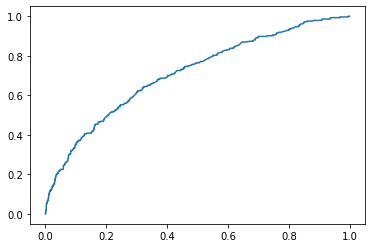

In [60]:
tpr, fpr, _ = roc_curve(y_test, prob[:,1])
plt.plot(tpr,fpr)
# pd.Series(xgb.feature_importances_,x.columns).sort_values(ascending=False)

In [62]:
xgb = XGBClassifier(n_estimators=200,max_depth=7, learning_rate = 0.1, gamma=0.5)
xgb.fit(x_train, y_train, eval_metric='auc', eval_set=[(x_train,y_train),(x_val,y_val)], early_stopping_rounds=3,verbose=2)
pred = xgb.predict(x_test)
prob = xgb.predict_proba(x_test)

print('auc:',roc_auc_score(y_test,prob[:,1]))
print(classification_report(y_test,pred))

[0]	validation_0-auc:0.74524	validation_1-auc:0.56646
[2]	validation_0-auc:0.86789	validation_1-auc:0.62670
[4]	validation_0-auc:0.89214	validation_1-auc:0.64971
[6]	validation_0-auc:0.91018	validation_1-auc:0.67020
[8]	validation_0-auc:0.93067	validation_1-auc:0.69060
[10]	validation_0-auc:0.94451	validation_1-auc:0.69558
[12]	validation_0-auc:0.95587	validation_1-auc:0.70821
[14]	validation_0-auc:0.96919	validation_1-auc:0.70947
[16]	validation_0-auc:0.97349	validation_1-auc:0.72045
[18]	validation_0-auc:0.97903	validation_1-auc:0.72254
[20]	validation_0-auc:0.98246	validation_1-auc:0.73278
[22]	validation_0-auc:0.98502	validation_1-auc:0.73613
[24]	validation_0-auc:0.98638	validation_1-auc:0.74114
[26]	validation_0-auc:0.98959	validation_1-auc:0.75068
[28]	validation_0-auc:0.99164	validation_1-auc:0.75806
[30]	validation_0-auc:0.99196	validation_1-auc:0.76129
[32]	validation_0-auc:0.99359	validation_1-auc:0.76619
[34]	validation_0-auc:0.99464	validation_1-auc:0.77195
[36]	validation

In [63]:
pred = xgb.predict(test.drop(['mtag','target'],axis=1))
prob = xgb.predict_proba(test.drop(['mtag','target'],axis=1))

print('auc:',roc_auc_score(test['mtag'],prob[:,1]))
print(classification_report(test['mtag'],pred))

auc: 0.6124598898104983
              precision    recall  f1-score   support

         0.0       0.55      0.99      0.71       199
         1.0       0.83      0.03      0.06       166

    accuracy                           0.56       365
   macro avg       0.69      0.51      0.38       365
weighted avg       0.68      0.56      0.41       365



In [ ]:
import pickle

In [64]:
spi

,일시,SPI1,SPI2,SPI3,SPI4,SPI5,SPI6,SPI9,SPI12,SPI18,SPI24,target,mtag
0,1996-01-01,-2.010,-0.922,-0.518,-1.415,1.155,1.125,0.795,0.724,-0.032,-0.034,0,1.0
1,1996-01-02,-1.882,-0.830,-0.556,-1.318,1.222,1.137,0.800,0.723,-0.018,-0.036,0,0.0
2,1996-01-03,-1.586,-0.833,-0.556,-1.352,1.249,1.153,0.804,0.723,0.003,-0.037,0,0.0
3,1996-01-04,-1.543,-0.862,-0.571,-1.216,1.293,1.166,0.801,0.722,0.045,-0.037,0,0.0
4,1996-01-05,-1.484,-0.838,-0.572,-1.147,1.363,1.100,0.806,0.721,0.060,-0.038,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,2021-12-27,0.600,-0.060,0.290,0.300,-0.530,-0.980,-0.520,-0.430,0.360,0.250,0,NaN
9493,2021-12-28,0.660,-0.020,0.320,0.400,-0.450,-1.120,-0.600,-0.430,0.370,0.250,0,NaN
9494,2021-12-29,0.710,0.000,0.320,0.480,-0.380,-1.110,-0.630,-0.430,0.370,0.250,0,NaN
9495,2021-12-30,0.820,0.000,0.140,0.540,-0.330,-1.130,-0.630,-0.430,0.370,0.250,0,NaN


In [294]:
dat = spi[['일시']]
col_feature = 'SPI6'
col_target = 'SPI6'

tmp = pd.DataFrame()
tmp2 = pd.DataFrame()

for i in range(90):
    dat[f't3-{i}'] = spi['SPI12'].shift(i)
    dat[f't6-{i}'] = spi['SPI3'].shift(i)
    tmp[f'일강수량-{i}'] = cli_seoul['일강수량'].shift(i)
    tmp2[f'평균증기압-{i}'] = cli_seoul['평균 증기압'].shift(i)
e_day = 30
dat[f'est+{e_day}'] = spi[col_target].shift(-1 * e_day)
dat['평균 강수량'] = tmp.mean(axis=1)
dat['평균 증기압'] = tmp2.mean(axis=1)

dat['평균 강수량1'] = cli_seoul['일강수량']
dat['평균 증기압1'] = cli_seoul['평균 증기압']


In [295]:
dat['연속무강수'] = np.where(cli_seoul['일강수량']>0,0,1)
dat['연속무강수'] = dat['연속무강수'].mul(dat['연속무강수'].cumsum()).diff().where(lambda x: x<0).ffill().add(dat['연속무강수'].cumsum(),fill_value=0)

In [296]:
dat

,일시,t3-0,t6-0,t3-1,t6-1,t3-2,t6-2,t3-3,t6-3,t3-4,...,t3-88,t6-88,t3-89,t6-89,est+30,평균 강수량,평균 증기압,평균 강수량1,평균 증기압1,연속무강수
0,1996-01-01,0.724,-0.518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.145,0.000000,1.300000,0.0,1.3,1.0
1,1996-01-02,0.723,-0.556,0.724,-0.518,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.213,0.000000,2.300000,0.0,3.3,2.0
2,1996-01-03,0.723,-0.556,0.723,-0.556,0.724,-0.518,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.233,0.000000,2.233333,0.0,2.1,3.0
3,1996-01-04,0.722,-0.571,0.723,-0.556,0.723,-0.556,0.724,-0.518,NaN,...,NaN,NaN,NaN,NaN,1.277,0.000000,2.075000,0.0,1.6,4.0
4,1996-01-05,0.721,-0.572,0.722,-0.571,0.723,-0.556,0.723,-0.556,0.724,...,NaN,NaN,NaN,NaN,1.342,0.400000,2.520000,2.0,4.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,2021-12-27,-0.430,0.290,-0.430,0.270,-0.430,0.270,-0.430,0.210,-0.420,...,-0.30,-1.07,-0.34,-1.11,NaN,1.557778,8.911111,0.0,2.2,3.0
9493,2021-12-28,-0.430,0.320,-0.430,0.290,-0.430,0.270,-0.430,0.270,-0.430,...,-0.42,-1.08,-0.30,-1.07,NaN,1.412222,8.703333,0.0,3.3,4.0
9494,2021-12-29,-0.430,0.320,-0.430,0.320,-0.430,0.290,-0.430,0.270,-0.430,...,-0.38,-0.93,-0.42,-1.08,NaN,1.414444,8.535556,0.2,4.6,0.0
9495,2021-12-30,-0.430,0.140,-0.430,0.320,-0.430,0.320,-0.430,0.290,-0.430,...,-0.38,-0.89,-0.38,-0.93,NaN,1.266667,8.356667,0.0,2.2,1.0


In [297]:
test = dat[dat['일시'].astype('datetime64').dt.year == 2019]
train = pd.concat([dat.loc[:8400], dat.loc[8766:]])
train

,일시,t3-0,t6-0,t3-1,t6-1,t3-2,t6-2,t3-3,t6-3,t3-4,...,t3-88,t6-88,t3-89,t6-89,est+30,평균 강수량,평균 증기압,평균 강수량1,평균 증기압1,연속무강수
0,1996-01-01,0.724,-0.518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.145,0.000000,1.300000,0.0,1.3,1.0
1,1996-01-02,0.723,-0.556,0.724,-0.518,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.213,0.000000,2.300000,0.0,3.3,2.0
2,1996-01-03,0.723,-0.556,0.723,-0.556,0.724,-0.518,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.233,0.000000,2.233333,0.0,2.1,3.0
3,1996-01-04,0.722,-0.571,0.723,-0.556,0.723,-0.556,0.724,-0.518,NaN,...,NaN,NaN,NaN,NaN,1.277,0.000000,2.075000,0.0,1.6,4.0
4,1996-01-05,0.721,-0.572,0.722,-0.571,0.723,-0.556,0.723,-0.556,0.724,...,NaN,NaN,NaN,NaN,1.342,0.400000,2.520000,2.0,4.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,2021-12-27,-0.430,0.290,-0.430,0.270,-0.430,0.270,-0.430,0.210,-0.420,...,-0.30,-1.07,-0.34,-1.11,NaN,1.557778,8.911111,0.0,2.2,3.0
9493,2021-12-28,-0.430,0.320,-0.430,0.290,-0.430,0.270,-0.430,0.270,-0.430,...,-0.42,-1.08,-0.30,-1.07,NaN,1.412222,8.703333,0.0,3.3,4.0
9494,2021-12-29,-0.430,0.320,-0.430,0.320,-0.430,0.290,-0.430,0.270,-0.430,...,-0.38,-0.93,-0.42,-1.08,NaN,1.414444,8.535556,0.2,4.6,0.0
9495,2021-12-30,-0.430,0.140,-0.430,0.320,-0.430,0.320,-0.430,0.290,-0.430,...,-0.38,-0.89,-0.38,-0.93,NaN,1.266667,8.356667,0.0,2.2,1.0


In [298]:
x = train.dropna().drop(['일시',f'est+{e_day}'],axis=1)
y = train.dropna()[f'est+{e_day}']
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.2,random_state=150)

In [299]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
svr = SVR()
lr = LinearRegression()
rfr = RandomForestRegressor()
xgbr = XGBRegressor()
adar = AdaBoostRegressor()
models = [svr, rfr, xgbr]

score :  0.7667949379169652
mse : 0.2412875239240035
score :  0.9580814591429966
mse : 0.04337136097968663
score :  0.9561683466906405
mse : 0.04535077841811595


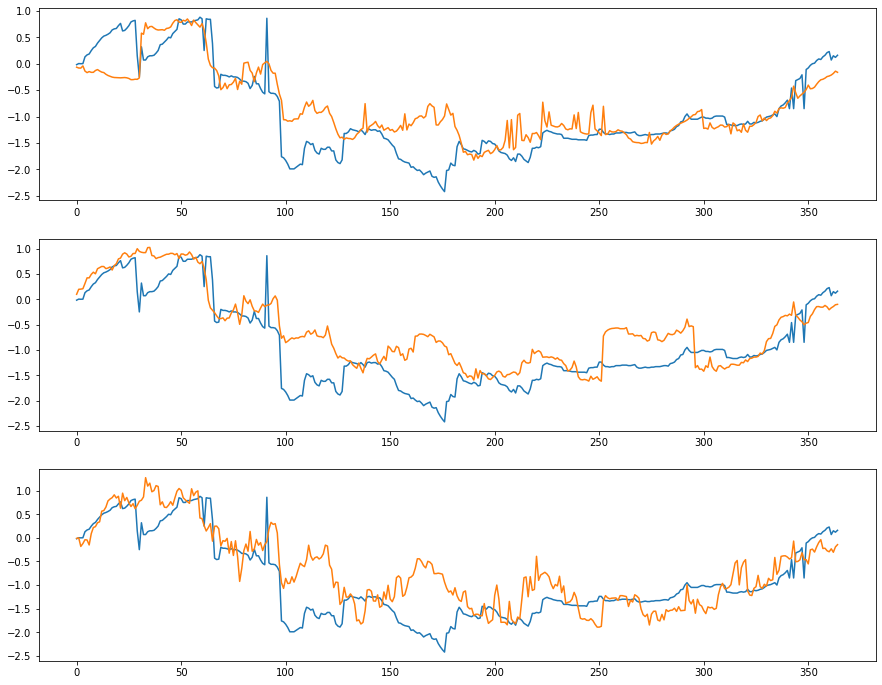

In [300]:
plt.figure(figsize=(15,12))
for i,m in enumerate(models[:-1]):
    m.fit(x_train, y_train)
    pred = m.predict(x_val)
    print('score : ', m.score(x_val,y_val))
    print('mse :', mean_squared_error(y_val,pred))
    ax = plt.subplot(len(models),1,i+1)
    ax.plot(test[f'est+{e_day}'].reset_index(drop=True))
    ax.plot(m.predict(test.drop(['일시',f'est+{e_day}'],axis=1).reset_index(drop=True)))

xgbr.fit(x_train, y_train, eval_metric = 'rmse', eval_set=[(x_train,y_train),(x_val,y_val)], early_stopping_rounds=5,verbose=0)
pred = xgbr.predict(x_val)
print('score : ', xgbr.score(x_val,y_val))
print('mse :', mean_squared_error(y_val,pred))
ax = plt.subplot(len(models),1,i+2)
ax.plot(test[f'est+{e_day}'].reset_index(drop=True))
ax.plot(xgbr.predict(test.drop(['일시',f'est+{e_day}'],axis=1).reset_index(drop=True)))